# Thompson Sampling (SDSS)

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedShuffleSplit
from mclearn.active import run_bandit_expt
from mclearn.heuristics import (random_h, entropy_h, margin_h, qbb_kl_h, qbb_margin_h,
                               pool_entropy_h, pool_variance_h)
from mclearn.tools import results_exist, load_results
from mclearn.preprocessing import balanced_train_test_split
from mclearn.viz import (plot_heuristic_selections, plot_bandit_parameters,
                         plot_cumulative_rewards, plot_sum_selections)
%matplotlib inline
sns.set_style('ticks')

## Setting Up

In [3]:
running_expt = False # set to False if only want to load in results
fig_dir = '../thesis/figures/'
target_col = 'class'
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']
xrange50 = np.arange(50, 301)
xrange51 = np.arange(51, 301)
colors = {'Random': '#e6ab02',
          'Entropy': '#e7298a',
          'Margin': '#d95f02',
          'QBB Margin': '#1b9e77',
          'QBB KL': '#66a61e',
          'Pool Variance': '#7570b3',
          'Pool Entropy': '#a6761d',
          'Thompson': '#666666'}
linestyles = {'Random': '-',
              'Entropy': '-',
              'Margin': '-',
              'QBB Margin': '-',
              'QBB KL': '-',
              'Pool Variance': '-',
              'Pool Entropy': '-',
              'Thompson': '-'}
labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL', 'Pool Variance', 'Pool Entropy']

In [4]:
if running_expt:
    sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
    transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
    X = np.array(sdss[sdss_features])
    X_poly = transformer.fit_transform(X)
    y = np.array(sdss[target_col])

## Balanced: Logistic Regression

In [5]:
if running_expt:
    logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    logistic_committee = BaggingClassifier(logistic, n_estimators=11, n_jobs=-1, max_samples=300)

    X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=900000, test_size=0, random_state=11)
    kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [6]:
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
pickle_paths = ['../pickle/07_thompson_sampling/sdss_balanced_logistic_thompson.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_frequencies.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, logistic, logistic_committee, heuristics, pickle_paths)

bl_lcs, bl_heuristics, bl_mus, bl_sigmas, bl_candidates = load_results(pickle_paths)

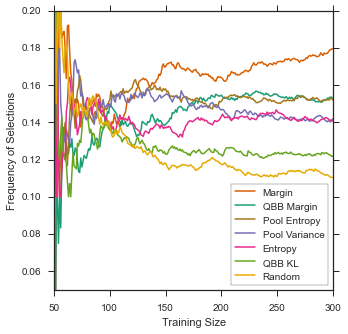

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = plot_heuristic_selections(xrange51, bl_heuristics, labels, colors, linestyles, ylim=(.05, .2))
fig.savefig(fig_dir + '5_thompson/sdss_bl_frequencies.pdf', bbox_inches='tight')

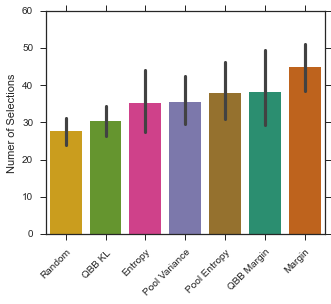

In [8]:
fig = plt.figure(figsize=(5, 4))
ax = plot_sum_selections(xrange51, bl_heuristics, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_bl_no_selections.pdf', bbox_inches='tight')

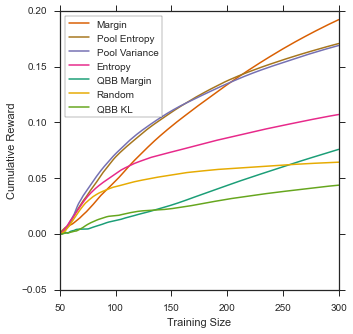

In [9]:
fig = plt.figure(figsize=(5, 5))
ax = plot_cumulative_rewards(xrange50, bl_mus, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_bl_sum_rewards.pdf', bbox_inches='tight')

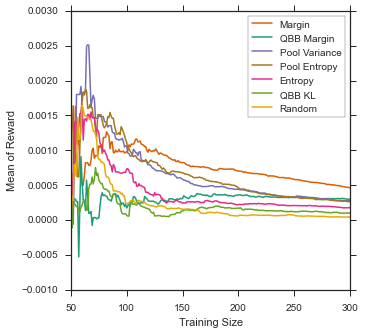

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, bl_mus, labels, colors, linestyles, ylabel='Mean of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_bl_avg_rewards.pdf', bbox_inches='tight')

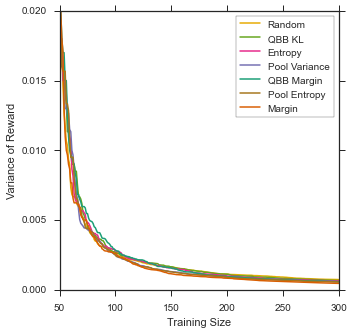

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, bl_sigmas, labels, colors, linestyles, ylabel='Variance of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_bl_sigmas.pdf', bbox_inches='tight')

## Balanced: SVM RBF

In [12]:
if running_expt:
    rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto', probability=True)
    rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

    X_pool, _, y_pool, _ = balanced_train_test_split(X, y, train_size=900000, test_size=0, random_state=11)
    kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [13]:
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
pickle_paths = ['../pickle/07_thompson_sampling/sdss_balanced_rbf_thompson.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_frequencies.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_balanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_pool, y_pool, kfold, rbf, rbf_committee, heuristics, pickle_paths)

br_lcs, br_heuristics, br_mus, br_sigmas, br_candidates = load_results(pickle_paths)

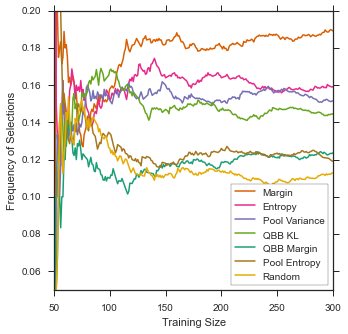

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = plot_heuristic_selections(xrange51, br_heuristics, labels, colors, linestyles, ylim=(.05, .2))
fig.savefig(fig_dir + '5_thompson/sdss_br_frequencies.pdf', bbox_inches='tight')

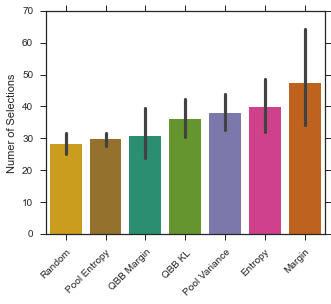

In [15]:
fig = plt.figure(figsize=(5, 4))
ax = plot_sum_selections(xrange51, br_heuristics, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_br_no_selections.pdf', bbox_inches='tight')

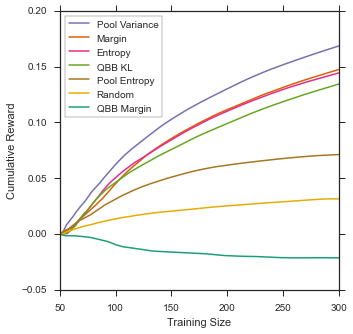

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = plot_cumulative_rewards(xrange50, br_mus, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_br_sum_rewards.pdf', bbox_inches='tight')

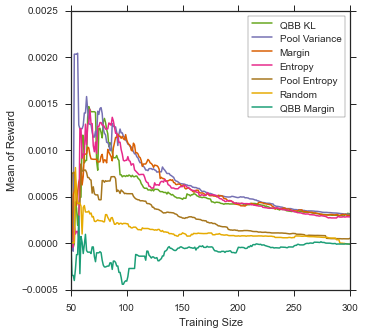

In [17]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, br_mus, labels, colors, linestyles, ylabel='Mean of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_br_avg_rewards.pdf', bbox_inches='tight')

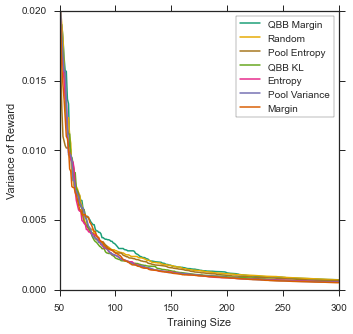

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, br_sigmas, labels, colors, linestyles, ylabel='Variance of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_br_sigmas.pdf', bbox_inches='tight')

## Unbalanced: Logistic Regression

In [19]:
if running_expt:
    logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=1, random_state=2, class_weight='auto')
    logistic_committee = BaggingClassifier(logistic, n_estimators=11, n_jobs=-1, max_samples=300)

    kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [20]:
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
pickle_paths = ['../pickle/07_thompson_sampling/sdss_unbalanced_logistic_thompson.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_frequencies.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_logistic_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X_poly, y, kfold, logistic, logistic_committee, heuristics, pickle_paths)

ul_lcs, ul_heuristics, ul_mus, ul_sigmas, ul_candidates = load_results(pickle_paths)

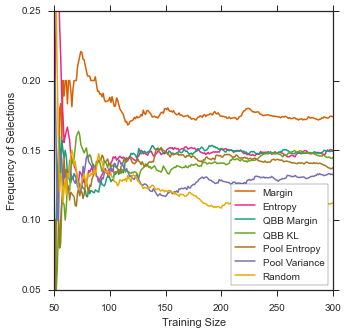

In [35]:
fig = plt.figure(figsize=(5, 5))
ax = plot_heuristic_selections(xrange51, ul_heuristics, labels, colors, linestyles, ylim=(.05, .25))
fig.savefig(fig_dir + '5_thompson/sdss_ul_frequencies.pdf', bbox_inches='tight')

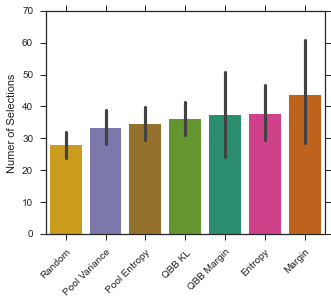

In [22]:
fig = plt.figure(figsize=(5, 4))
ax = plot_sum_selections(xrange51, ul_heuristics, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_ul_no_selections.pdf', bbox_inches='tight')

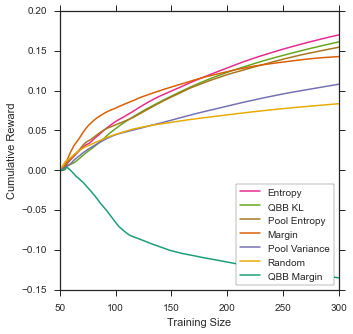

In [38]:
fig = plt.figure(figsize=(5, 5))
ax = plot_cumulative_rewards(xrange50, ul_mus, labels, colors, linestyles, loc='lower right')
fig.savefig(fig_dir + '5_thompson/sdss_ul_sum_rewards.pdf', bbox_inches='tight')

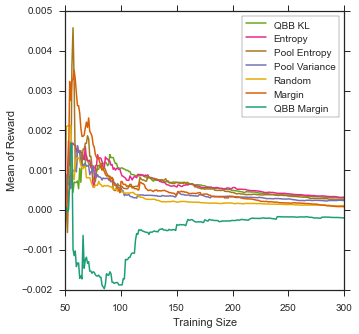

In [24]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, ul_mus, labels, colors, linestyles, ylabel='Mean of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_ul_avg_rewards.pdf', bbox_inches='tight')

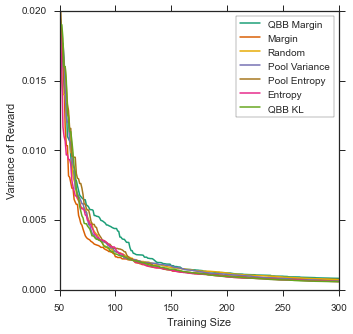

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, ul_sigmas, labels, colors, linestyles, ylabel='Variance of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_ul_sigmas.pdf', bbox_inches='tight')

## Unbalanced: SVM RBF

In [26]:
if running_expt:
    rbf = SVC(kernel='rbf', gamma=0.1, C=10, cache_size=2000, class_weight='auto', probability=True)
    rbf_committee = BaggingClassifier(rbf, n_estimators=11, n_jobs=-1, max_samples=300)

    kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=10000, train_size=10000, random_state=19)

In [27]:
heuristics = [random_h, entropy_h, margin_h, qbb_margin_h, qbb_kl_h, pool_variance_h, pool_entropy_h]
pickle_paths = ['../pickle/07_thompson_sampling/sdss_unbalanced_rbf_thompson.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_frequencies.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_mus.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_sigmas.pickle',
                '../pickle/07_thompson_sampling/sdss_unbalanced_rbf_candidates.pickle']

if not results_exist(pickle_paths):
    run_bandit_expt(X, y, kfold, rbf, rbf_committee, heuristics, pickle_paths)

ur_lcs, ur_heuristics, ur_mus, ur_sigmas, ur_candidates = load_results(pickle_paths)

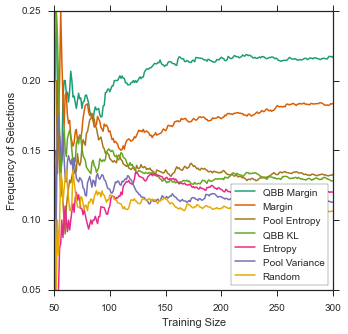

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = plot_heuristic_selections(xrange51, ur_heuristics, labels, colors, linestyles, ylim=(.05, .25))
fig.savefig(fig_dir + '5_thompson/sdss_ur_frequencies.pdf', bbox_inches='tight')

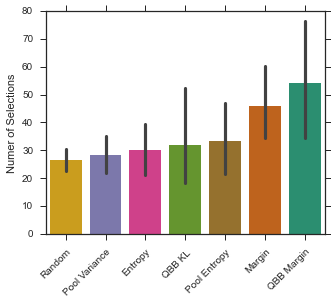

In [29]:
fig = plt.figure(figsize=(5, 4))
ax = plot_sum_selections(xrange51, ur_heuristics, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_ur_no_selections.pdf', bbox_inches='tight')

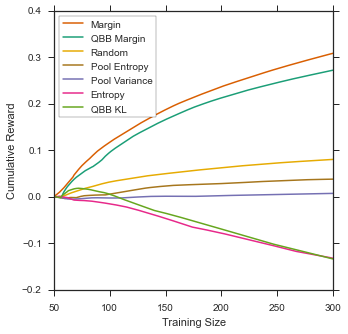

In [30]:
fig = plt.figure(figsize=(5, 5))
ax = plot_cumulative_rewards(xrange50, ur_mus, labels, colors, linestyles)
fig.savefig(fig_dir + '5_thompson/sdss_ur_sum_rewards.pdf', bbox_inches='tight')

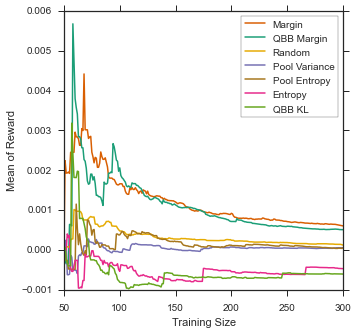

In [31]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, ur_mus, labels, colors, linestyles, ylabel='Mean of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_ur_avg_rewards.pdf', bbox_inches='tight')

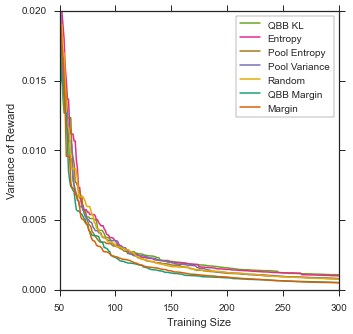

In [32]:
fig = plt.figure(figsize=(5, 5))
ax = plot_bandit_parameters(xrange50, ur_sigmas, labels, colors, linestyles, ylabel='Variance of Reward')
fig.savefig(fig_dir + '5_thompson/sdss_ur_sigmas.pdf', bbox_inches='tight')